In [1]:
import os
import pickle
import joblib
import pandas as pd
import mediapipe as mp
import cv2
import matplotlib.pyplot as plt
import tqdm
import numpy as np

ModuleNotFoundError: No module named 'tqdm'

In [2]:
# objects for mediapipe
mp_hands = mp.solutions.hands
mp_drawing = mp.solutions.drawing_utils
mp_drawing_styles = mp.solutions.drawing_styles

hands = mp_hands.Hands(static_image_mode=False, min_detection_confidence=0.3, min_tracking_confidence=0.3, max_num_hands=1, model_complexity=1)

In [ ]:
## Conectar kaggle API y bajar el dataset

# from google.colab import files
# files.upload()

# !pip install kaggle

# !mkdir ~/.kaggle
# !cp kaggle.json ~/.kaggle/
# !chmod 600 ~/.kaggle/kaggle.json
# !pwd

# !kaggle datasets download -d grassknoted/asl-alphabet
# !unzip asl-alphabet.zip

## Data processing

### First we will plot the first image of each directory

c:\Users\DELL\AppData\Local\Programs\Python\Python312\Lib\site-packages\google\protobuf\symbol_database.py:55: UserWarning: SymbolDatabase.GetPrototype() is deprecated. Please use message_factory.GetMessageClass() instead. SymbolDatabase.GetPrototype() will be removed soon.
  warnings.warn('SymbolDatabase.GetPrototype() is deprecated. Please '
C:\Users\DELL\AppData\Local\Temp\ipykernel_18744\1464278034.py:21: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  plt.figure()


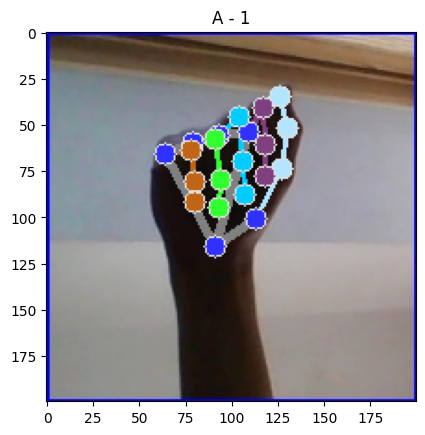

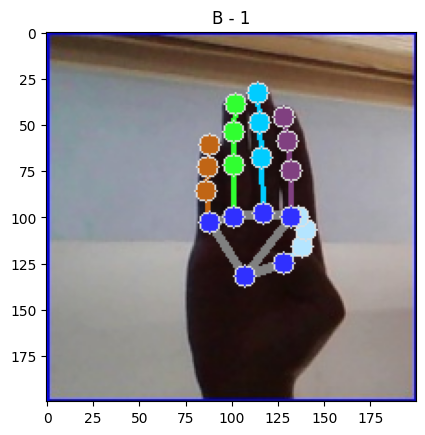

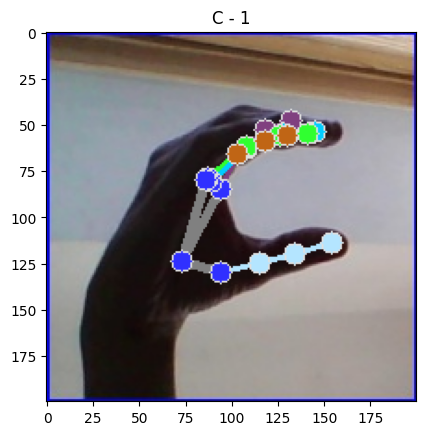

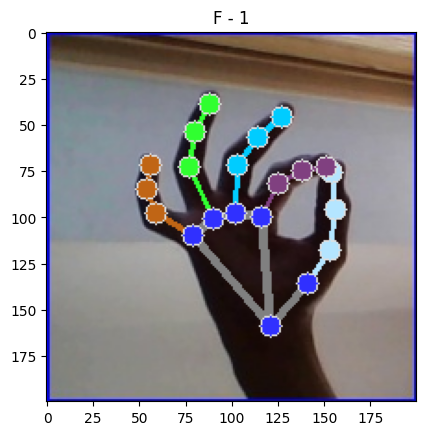

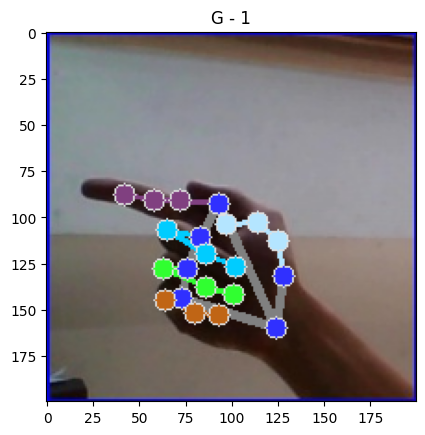

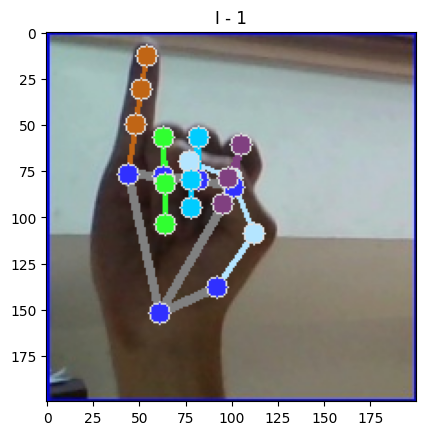

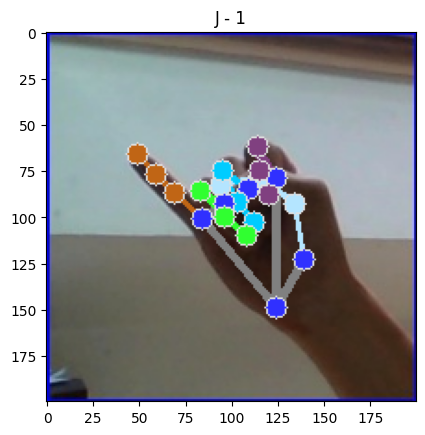

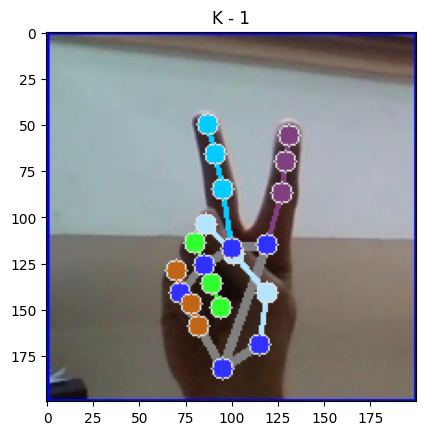

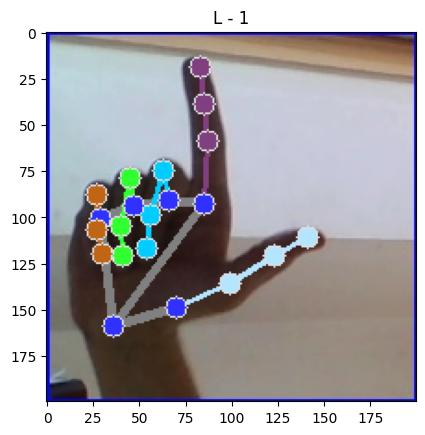

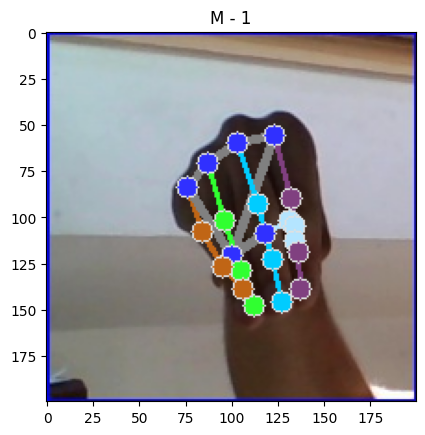

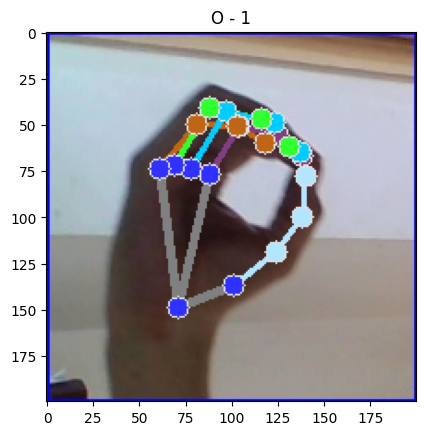

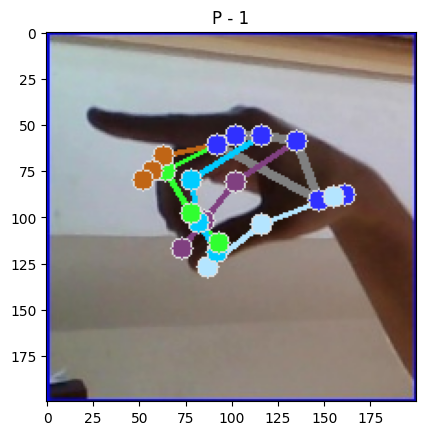

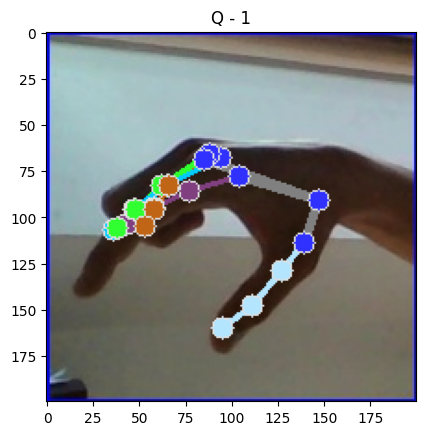

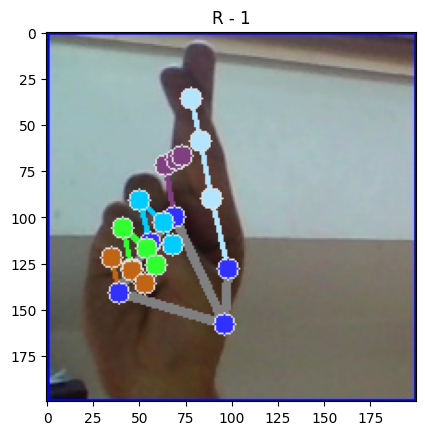

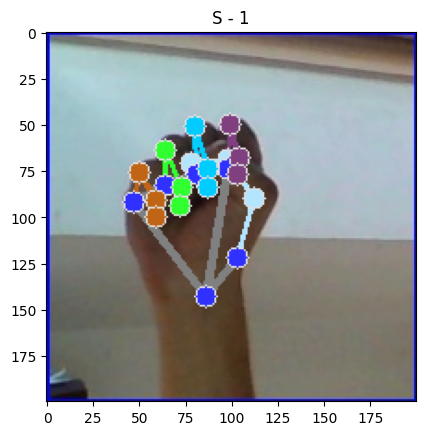

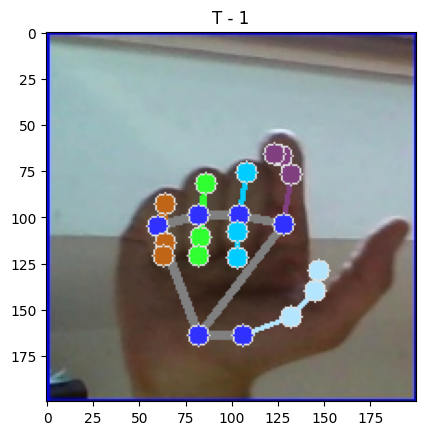

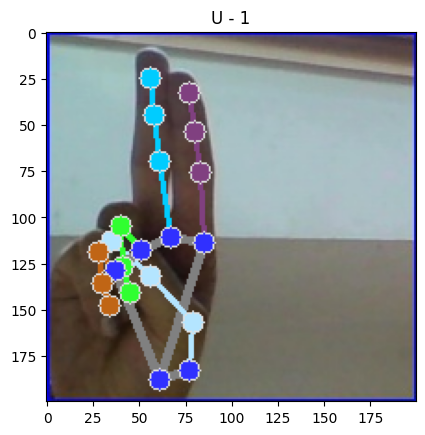

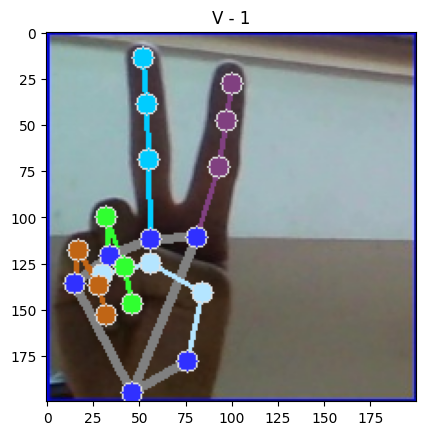

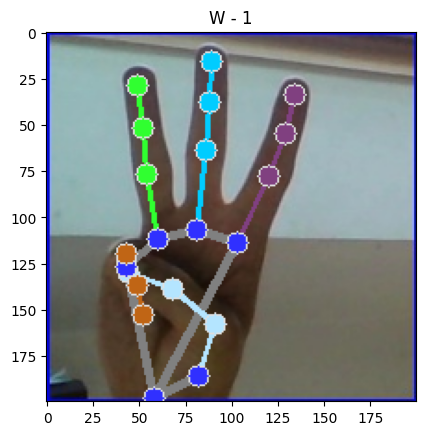

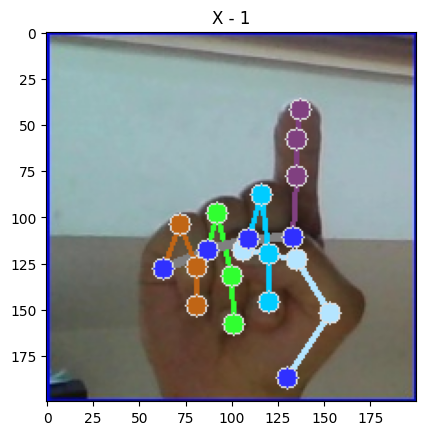

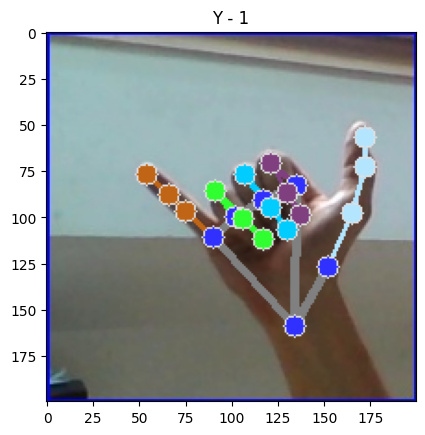

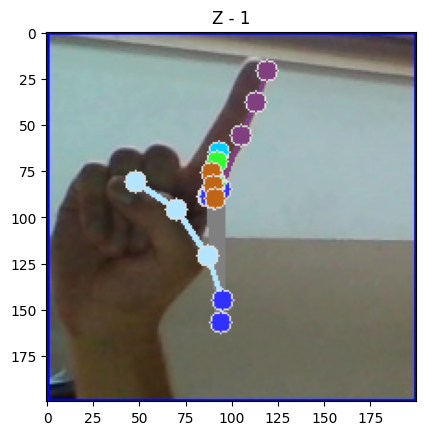

In [15]:
DATA_DIR = r'C:\Users\DELL\Desktop\HACKABOSS\Project_3_ASL\asl_alphabet_train\asl_alphabet_train'

for dir_ in os.listdir(DATA_DIR):
    for img_path in os.listdir(os.path.join(DATA_DIR, dir_))[:1]:
        img = cv2.imread(os.path.join(DATA_DIR, dir_, img_path))

        # hay que convertir la imagen a RGB porque mediapipe usa RGB.
        img_rg = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

        results = hands.process(img_rg)
        if results.multi_hand_landmarks:
        
            for hand_landmarks in results.multi_hand_landmarks:
                mp_drawing.draw_landmarks(
                    img_rg,
                    hand_landmarks,
                    mp_hands.HAND_CONNECTIONS,
                    mp_drawing_styles.get_default_hand_landmarks_style(),
                    mp_drawing_styles.get_default_hand_connections_style()
                )
                plt.figure()
                # count images in each class
                plt.title(f'{dir_} - {len(os.listdir(os.path.join(DATA_DIR, dir_))[:1])}')
                
                plt.imshow(img_rg)

plt.show()

### Coordenadas de hand landmarks

In [16]:
for i in range(len(hand_landmarks.landmark)):
    print(i, hand_landmarks.landmark[i])


0 x: 0.470717072
y: 0.789469719
z: 9.80141e-007

1 x: 0.475061625
y: 0.726599932
z: -0.112595409

2 x: 0.438795149
y: 0.605734169
z: -0.158646286

3 x: 0.352902561
y: 0.480363846
z: -0.188056082

4 x: 0.240586102
y: 0.408116072
z: -0.213594362

5 x: 0.474012047
y: 0.42512098
z: -0.0717697069

6 x: 0.526090145
y: 0.283205569
z: -0.116380416

7 x: 0.567740917
y: 0.190045804
z: -0.153951019

8 x: 0.598749101
y: 0.109603137
z: -0.180306569

9 x: 0.458032906
y: 0.409158707
z: -0.0362644531

10 x: 0.465381026
y: 0.327504903
z: -0.0982411206

11 x: 0.451992333
y: 0.395559341
z: -0.130213022

12 x: 0.437480271
y: 0.445344448
z: -0.137754768

13 x: 0.450043052
y: 0.42021361
z: -0.0113273486

14 x: 0.464368254
y: 0.353072524
z: -0.0657878

15 x: 0.457189471
y: 0.41144073
z: -0.0712094307

16 x: 0.450115681
y: 0.451285481
z: -0.0588284694

17 x: 0.441545188
y: 0.44985655
z: 0.00508301053

18 x: 0.448988616
y: 0.382832766
z: -0.0293866806

19 x: 0.451102138
y: 0.416033447
z: -0.0252357237

20 x: 0

## Creamos nuestro dataset y hacemos data augmentation

In [17]:
# Initialize mediapipe components
mp_hands = mp.solutions.hands

# Set the data directory
DATA_DIR = r'C:\Users\DELL\Desktop\HACKABOSS\Project_3_ASL\asl_alphabet_train\asl_alphabet_train'

data = []
labels = []

# Define data augmentation functions
def rotate_image(image, angle):
    center = (image.shape[1] // 2, image.shape[0] // 2)
    matrix = cv2.getRotationMatrix2D(center, angle, 1.0)
    rotated_image = cv2.warpAffine(image, matrix, (image.shape[1], image.shape[0]))
    return rotated_image

def zoom_image(image, zoom_factor):
    if zoom_factor == 1:
        return image
    height, width = image.shape[:2]
    center = (width / 2, height / 2)
    matrix = cv2.getRotationMatrix2D(center, 0, zoom_factor)
    zoomed_image = cv2.warpAffine(image, matrix, (width, height))
    return zoomed_image

# Use mediapipe hands
with mp_hands.Hands(static_image_mode=False, max_num_hands=2, min_detection_confidence=0.5, min_tracking_confidence=0.5) as hands:
    # Get the list of directories
    dirs = [dir_ for dir_ in os.listdir(DATA_DIR) if os.path.isdir(os.path.join(DATA_DIR, dir_))]
    
    # Create the progress bar
    for dir_ in tqdm.tqdm(dirs, desc="Processing directories"):
        dir_path = os.path.join(DATA_DIR, dir_)
        try:
            for img_path in os.listdir(dir_path):
                # Read original image
                full_img_path = os.path.join(dir_path, img_path)
                img = cv2.imread(full_img_path)
                if img is None:
                    print(f'Failed to read image: {full_img_path}')
                    continue

                # List of transformations to apply
                transformations = [
                    lambda x: x,  # No transformation
                    lambda x: rotate_image(x, 15),  # Rotate 15 degrees
                    lambda x: rotate_image(x, -15), # Rotate -15 degrees
                    lambda x: zoom_image(x, 1.2),   # Zoom in
                    lambda x: zoom_image(x, 0.6),
                    # lambda x: zoom_image(x, 0.4)     # Zoom out
                ]

                for transform in transformations:
                    img_transformed = transform(img)
                    img_rgb = cv2.cvtColor(img_transformed, cv2.COLOR_BGR2RGB)
                    results = hands.process(img_rgb)

                    if results.multi_hand_landmarks:
                        for hand_landmarks in results.multi_hand_landmarks:
                            data_aux = []
                            x_ = []
                            y_ = []
                            
                            for i in range(len(hand_landmarks.landmark)):
                                x = hand_landmarks.landmark[i].x
                                y = hand_landmarks.landmark[i].y

                                x_.append(x)
                                y_.append(y)

                            for i in range(len(hand_landmarks.landmark)):
                                x = hand_landmarks.landmark[i].x
                                y = hand_landmarks.landmark[i].y

                                # Normalize the coordinates
                                data_aux.append(x - min(x_))
                                data_aux.append(y - min(y_))

                            
                            data.append(data_aux)
                            labels.append(dir_)
        except Exception as e:
            print(f'Error processing directory {dir_}: {e}')

print("Processing complete.")

# create dataframe 

df = pd.DataFrame(data)
df['Labels'] = labels

#Vamos a ignorar los labels 'del', 'nothing' y 'space' ya que no son letras
df = df[~df['Labels'].isin(['del','nothing','space'])]

# save the dataframe
df.to_csv('hand_landmarks_augment.csv', index=False)

Processing directories:   0%|          | 0/26 [00:00<?, ?it/s]

Processing directories: 100%|██████████| 26/26 [1:49:08<00:00, 251.85s/it]

Processing complete.


In [22]:
df.shape, df['label'].unique()

((60347, 43),
 array(['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M',
        'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z'],
       dtype=object))

## preparamos para training

In [23]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score

# Split the data into features and target
X = df.drop('label', axis=1)
y = df['label']


# Encode the target
le = LabelEncoder()
y = le.fit_transform(y)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=True, random_state=42, stratify=y)

# Create the model
model = RandomForestClassifier(n_estimators=100, random_state=42)

# Train the model
model.fit(X_train, y_train)

# Make predictions
y_pred = model.predict(X_test)

# Calculate the accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy}')

# predict.probabilities
y_pred_prob = model.predict_proba(X_test)
y_pred_prob

for i in range(20):
    print(f'predicted: {le.inverse_transform([y_pred[i]])}, real: {le.inverse_transform([y_test[i]])}')

Accuracy: 0.9911350455675227
predicted: ['X'], real: ['X']
predicted: ['B'], real: ['B']
predicted: ['O'], real: ['O']
predicted: ['X'], real: ['X']
predicted: ['O'], real: ['O']
predicted: ['G'], real: ['G']
predicted: ['T'], real: ['Z']
predicted: ['R'], real: ['R']
predicted: ['F'], real: ['F']
predicted: ['I'], real: ['I']
predicted: ['J'], real: ['J']
predicted: ['A'], real: ['A']
predicted: ['U'], real: ['U']
predicted: ['I'], real: ['I']
predicted: ['F'], real: ['F']
predicted: ['H'], real: ['H']
predicted: ['D'], real: ['D']
predicted: ['D'], real: ['D']
predicted: ['G'], real: ['G']
predicted: ['G'], real: ['G']


In [24]:
# Save the model
joblib.dump(model, 'model_landmarks_augment.pkl')

#save the label encoder
joblib.dump(le, 'label_encoder_augment.pkl')

['label_encoder_hand_landmarks.pkl']

## live-streaming

### Save the prediction with 'q'

### Put space with 'space'

In [20]:
import cv2
import mediapipe as mp
import joblib
import numpy as np
from collections import deque

# Initialize video capture
cap = cv2.VideoCapture(0)

# Initialize mediapipe Hands
mp_hands = mp.solutions.hands
mp_drawing = mp.solutions.drawing_utils
mp_drawing_styles = mp.solutions.drawing_styles

from mediapipe.python.solutions.drawing_utils import DrawingSpec

# Customize the styles
# give me more profesional ideas for the color of the landmarks and the connections
landmark_style = DrawingSpec(color=(0, 0, 0), thickness=2, circle_radius=2)
connection_style = DrawingSpec(color=(0, 0, 0), thickness=2)


# Set up the hand detection model
hands = mp_hands.Hands(static_image_mode=False, max_num_hands=2, min_detection_confidence=0.7, min_tracking_confidence=0.7)

# Load the pre-trained model and label encoder
model = joblib.load('model_landmarks_augment.pkl')
le = joblib.load('label_encoder_augment.pkl')


# Initialize variables to store predictions
last_predicted_gesture = ""
gesture_history = ""
predictions = deque(maxlen=10)  # A queue to store recent predictions for smoothing



while cap.isOpened():
    ret, frame = cap.read()

    if not ret:
        continue

    # Convert the image to RGB
    frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)

    # Process the frame to find hand landmarks
    results = hands.process(frame_rgb)

    H, W, _ = frame.shape

    if results.multi_hand_landmarks:
        for hand_landmarks in results.multi_hand_landmarks:
            # Draw the hand landmarks
            mp_drawing.draw_landmarks(
                frame,
                hand_landmarks,
                mp_hands.HAND_CONNECTIONS,
                landmark_style,
                connection_style
 
            )

            # Prepare data for prediction
            data = []
            x_ = []
            y_ = []

            for lm in hand_landmarks.landmark:
                x_.append(lm.x)
                y_.append(lm.y)

            for i in range(len(hand_landmarks.landmark)):
                data.append(hand_landmarks.landmark[i].x - min(x_))
                data.append(hand_landmarks.landmark[i].y - min(y_))

            # Predict the gesture
            prediction = model.predict([np.asarray(data)])
            predicted_character = le.inverse_transform(prediction)[0]

            # Smooth predictions
            predictions.append(predicted_character)
            smoothed_prediction = max(set(predictions), key=predictions.count)

            # Update last predicted gesture
            last_predicted_gesture = f'Predicted Gesture: {smoothed_prediction}'

            # Draw a bounding box around the hand
            x1, y1 = int(min(x_) * W) - 10, int(min(y_) * H) - 10
            x2, y2 = int(max(x_) * W) + 10, int(max(y_) * H) + 10
            cv2.rectangle(frame, (x1, y1), (x2, y2), (0, 0, 0), 4)

            # Put the predicted gesture on the frame
            cv2.putText(frame, smoothed_prediction, (x1, y1 - 10), cv2.FONT_HERSHEY_DUPLEX, 1.3, (0, 255, 0), 3, cv2.LINE_AA)

    # Define the position and size of the white box
    box_x, box_y = 10, H - 50
    box_w, box_h = W - 20, 40

    # Draw the white box for the gesture history
    cv2.rectangle(frame, (box_x, box_y), (box_x + box_w, box_y + box_h), (255, 255, 255), cv2.FILLED, cv2.LINE_AA)
    # Draw a black frame around the white box
    cv2.rectangle(frame, (box_x, box_y), (box_x + box_w, box_y + box_h), (0, 0, 0), 1, cv2.LINE_AA)

    # Put the gesture history text inside the white box
    cv2.putText(frame, f'WRITE HERE: {gesture_history}', (box_x + 5, box_y + 25), cv2.FONT_HERSHEY_DUPLEX, 0.4, (0, 0, 0), 1, cv2.LINE_AA)
    
    # Show the frame
    cv2.imshow('ASL Alphabet', frame)

    # Capture key press
    k = cv2.waitKey(2)
    if k % 256 == 27:  # ESC key
        print("Escape hit, closing...")
        break
    elif k % 256 == ord('q'):  # 'q' key
        # Concatenate to gesture history if 'L' key is pressed
        gesture_history += smoothed_prediction
    elif k % 256 == ord(' '):  # Space key
        # Add a space to gesture history if space key is pressed
        gesture_history += ' '

# Release the capture and destroy windows
cap.release()
cv2.destroyAllWindows()

# mirror my image to see the hand in the same way that the camera sees it but not the text
# mirror the image
frame = cv2.flip(frame, 1)
cv2.imshow('ASL Alphabet', frame)

# Release the capture and destroy windows
cap.release()
cv2.destroyAllWindows()


c:\Users\DELL\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\base.py:376: InconsistentVersionWarning: Trying to unpickle estimator DecisionTreeClassifier from version 1.4.1.post1 when using version 1.5.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
c:\Users\DELL\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\base.py:376: InconsistentVersionWarning: Trying to unpickle estimator RandomForestClassifier from version 1.4.1.post1 when using version 1.5.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
c:\Users\DELL\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\base.py:376: InconsistentVersionWarning: T

Escape hit, closing...


2nd try

In [60]:
import cv2
import mediapipe as mp
import joblib
import numpy as np
from collections import deque

# Initialize video capture
cap = cv2.VideoCapture(0)

# Initialize mediapipe Hands
mp_hands = mp.solutions.hands
mp_drawing = mp.solutions.drawing_utils
mp_drawing_styles = mp.solutions.drawing_styles

# Set up the hand detection model
hands = mp_hands.Hands(static_image_mode=False, max_num_hands=1, min_detection_confidence=0.7, min_tracking_confidence=0.7)

# Load the pre-trained model and label encoder
model = joblib.load('model_landmarks_rf_min_norm.pkl')
le = joblib.load('label_encoder_min_norm.pkl')

# Initialize variables to store predictions
last_predicted_gesture = ""
gesture_history = ""
predictions = deque(maxlen=10)  # A queue to store recent predictions for smoothing

# Function to extract hand landmarks as features
def extract_hand_features(hand_landmarks):
    data = []
    x_coords = [landmark.x for landmark in hand_landmarks.landmark]
    y_coords = [landmark.y for landmark in hand_landmarks.landmark]
    for i in range(len(hand_landmarks.landmark)):
        data.append(hand_landmarks.landmark[i].x - min(x_coords))
        data.append(hand_landmarks.landmark[i].y - min(y_coords))
    return np.asarray(data)

while cap.isOpened():
    ret, frame = cap.read()

    if not ret:
        continue

    # Convert the image to RGB
    frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)

    # Process the frame to find hand landmarks
    results = hands.process(frame_rgb)

    H, W, _ = frame.shape

    if results.multi_hand_landmarks:
        for hand_landmarks in results.multi_hand_landmarks:
            # Get the bounding box coordinates for the hand
            x_coords = [landmark.x for landmark in hand_landmarks.landmark]
            y_coords = [landmark.y for landmark in hand_landmarks.landmark]
            x_min = int(min(x_coords) * W)
            y_min = int(min(y_coords) * H)
            x_max = int(max(x_coords) * W)
            y_max = int(max(y_coords) * H)

            # Draw a rectangle around the hand
            cv2.rectangle(frame, (x_min, y_min), (x_max, y_max), (255, 0, 0), 2)

            # Extract features from hand landmarks
            hand_features = extract_hand_features(hand_landmarks)

            # Predict the gesture using the features
            prediction = model.predict([hand_features])
            predicted_character = le.inverse_transform(prediction)[0]

            # Smooth predictions
            predictions.append(predicted_character)
            smoothed_prediction = max(set(predictions), key=predictions.count)

            # Update last predicted gesture
            last_predicted_gesture = f'Predicted Gesture: {smoothed_prediction}'

            # Draw a bounding box around the hand with a margin
            x1, y1 = max(0, x_min - 10), max(0, y_min - 10)
            x2, y2 = min(W, x_max + 10), min(H, y_max + 10)
            cv2.rectangle(frame, (x1, y1), (x2, y2), (0, 0, 0), 4)

            # Put the predicted gesture on the frame
            cv2.putText(frame, smoothed_prediction, (x1, y1 - 10), cv2.FONT_HERSHEY_SIMPLEX, 1.3, (0, 0, 0), 3, cv2.LINE_AA)

    # Define the position and size of the white box
    box_x, box_y = 10, H - 50
    box_w, box_h = W - 20, 40

    # Draw the white box for the gesture history
    cv2.rectangle(frame, (box_x, box_y), (box_x + box_w, box_y + box_h), (255, 255, 255), cv2.FILLED)

    # Put the gesture history text inside the white box
    cv2.putText(frame, f'WRITE HERE: {gesture_history}', (box_x + 10, box_y + 30), cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0, 0, 0), 2, cv2.LINE_AA)

    # Show the frame
    cv2.imshow('ASL Alphabet', frame)

    # Capture key press
    k = cv2.waitKey(2)
    if k % 256 == 27:  # ESC key
        print("Escape hit, closing...")
        break
    elif k % 256 == ord('q'):  # 'Q' key
        # Concatenate to gesture history if 'Q' key is pressed
        gesture_history += smoothed_prediction
    elif k % 256 == ord(' '):  # Space key
        # Add a space to gesture history if space key is pressed
        gesture_history += ' '

# Release the capture and destroy windows
cap.release()
cv2.destroyAllWindows()



c:\Users\DELL\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
c:\Users\DELL\AppData\Local\Programs\Python\Python312\Lib\site-packages\google\protobuf\symbol_database.py:55: UserWarning: SymbolDatabase.GetPrototype() is deprecated. Please use message_factory.GetMessageClass() instead. SymbolDatabase.GetPrototype() will be removed soon.
  warnings.warn('SymbolDatabase.GetPrototype() is deprecated. Please '
c:\Users\DELL\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
c:\Users\DELL\AppData\Local\Programs\Python\Python312\Lib\site-packages\google\protobuf\symbol_database.py:55: UserWarning: SymbolDatabase.GetPrototype() is deprecated. Please use message_factory.GetMessageClass() instea

Escape hit, closing...
